In [167]:
import os 

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from dataset_generation import create_dataset

In [168]:
SAVED_DF_PATH = 'data/dataset.csv'
NUM_SAMPLES = 200

df = None
if os.path.exists(SAVED_DF_PATH):
    df = pd.read_csv(SAVED_DF_PATH)
else:
    df = create_dataset(NUM_SAMPLES)
    df.to_csv(SAVED_DF_PATH, header=True, index=False)

In [169]:
condition_mapping = {'dry': 0, 'wet': 1}
df['road_condition_numeric'] = df['road_condition'].map(condition_mapping)

In [170]:
# set None to 9999 for distances to objects
df['distance_to_obstacle'] = df['distance_to_obstacle'].fillna(9999)

In [171]:
df.sample(10, random_state=42)

,distance_to_obstacle,vehicle_speed,road_condition,road_condition_numeric
95,9999.000000,82.787,wet,1
15,9999.000000,67.681,wet,1
30,9999.000000,87.071,wet,1
158,9999.000000,141.266,dry,0
128,52.257043,51.203,dry,0
115,9999.000000,43.926,wet,1
69,9999.000000,21.979,dry,0
170,8.105296,122.113,wet,1
174,9999.000000,79.683,dry,0
45,9999.000000,59.105,dry,0


# Dataset generation and quality checks.
Given only 3 parameters to generate for each instance, I think we don't need to filter out any of the records.
That's because even "edge-cases" that may seem almost unreal, like a car that rushes at 150 km/h and the distance to the object is 1m, these cases can also be used as "critical" examples. 
In those cases, AI also should try to lower the damage, etc.

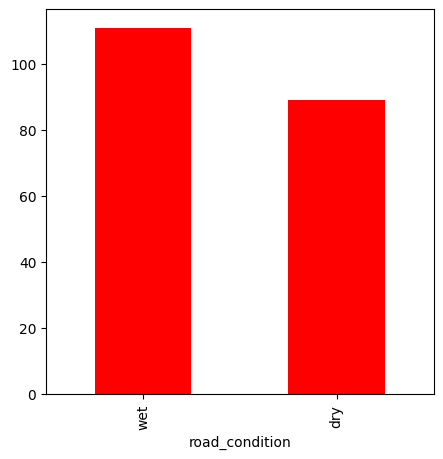

In [172]:
plt.figure(figsize=(5, 5))
df['road_condition'].value_counts().plot(kind='bar', color='red')
plt.show()

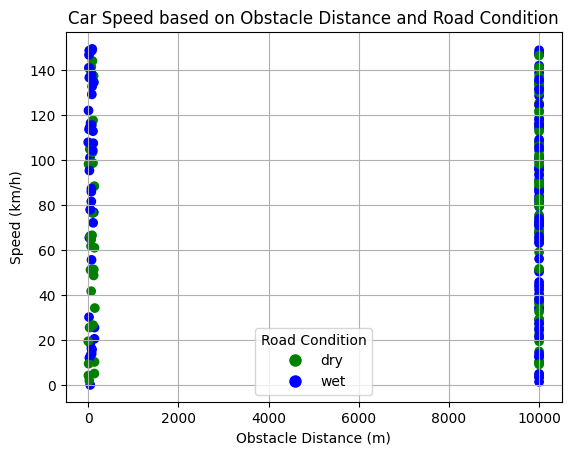

In [173]:
colors = {'dry': 'green', 'wet': 'blue'}
plt.scatter(df['distance_to_obstacle'], df['vehicle_speed'], c=df['road_condition'].map(colors), label=df['road_condition'].unique())

plt.title('Car Speed based on Obstacle Distance and Road Condition')
plt.xlabel('Obstacle Distance (m)')
plt.ylabel('Speed (km/h)')
plt.grid(True)

# Add a legend for road conditions
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[cond], markersize=10) for cond in colors]
plt.legend(handles, colors.keys(), title='Road Condition')

plt.show()

# Fuzzy sets, functions and rules creation
We are going to be using scikit-fuzzy

In [174]:
import skfuzzy as fuzz
import skfuzzy.control as ctrl

### Defining fuzzy sets for input variables

In [175]:
speed = ctrl.Antecedent(df['vehicle_speed'], 'speed')
distance = ctrl.Antecedent(df['distance_to_obstacle'], 'distance')
road_state = ctrl.Antecedent(df['road_condition_numeric'], 'road_state')

### Defining membership functions

In [176]:
SPEED_THRESHOLDS = [
    (0, 30, 30),
    (50, 90, 100),
    (90, 150, 150),
]

DISTANCE_THRESHOLDS = [
    (0, 0, 10),
    (40, 60, 80),
    (60, 100, 10_000)
]

In [177]:
distance['small'] = fuzz.trimf(distance.universe, DISTANCE_THRESHOLDS[0])
distance['medium'] = fuzz.trimf(distance.universe, DISTANCE_THRESHOLDS[1])
distance['large'] = fuzz.trimf(distance.universe, DISTANCE_THRESHOLDS[2])

speed['low'] = fuzz.trimf(speed.universe, SPEED_THRESHOLDS[0])
speed['medium'] = fuzz.trimf(speed.universe, SPEED_THRESHOLDS[1])
speed['high'] = fuzz.trimf(speed.universe, SPEED_THRESHOLDS[2])

road_state['dry'] = fuzz.trimf(road_state.universe, [0, 0, 0])
road_state['wet'] = fuzz.trimf(road_state.universe, [1, 1, 1])

C:\Users\volodymyr\.virtualenvs\computational_intelligence-ab0f9zpH\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


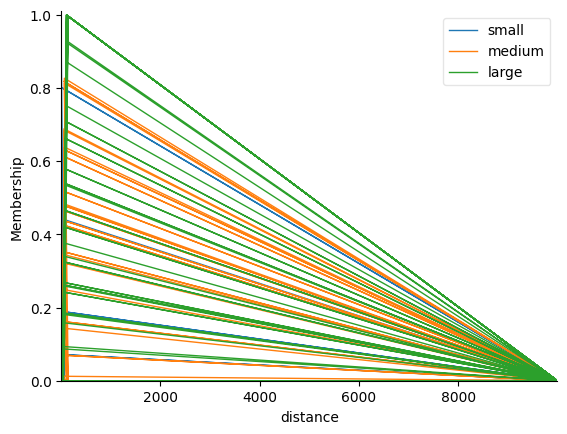

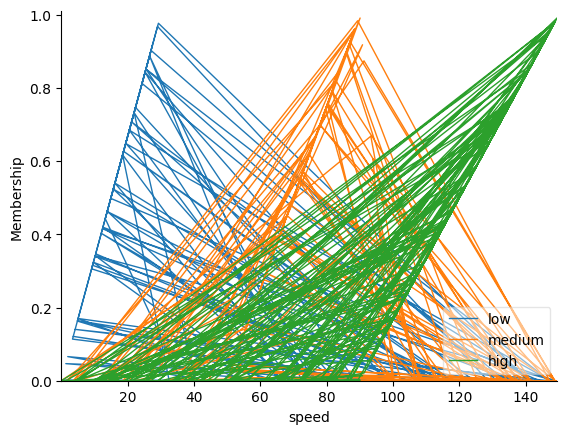

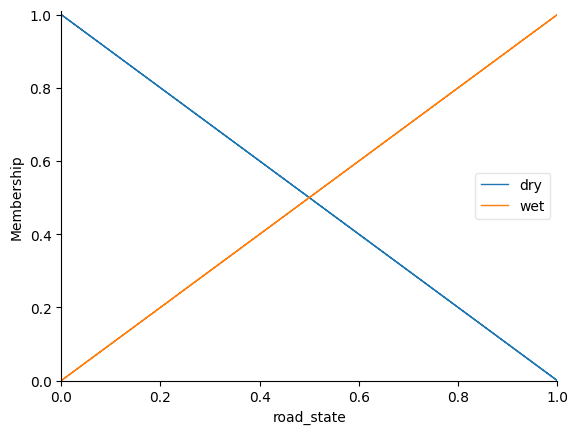

In [178]:
for variable in (distance, speed, road_state):
    variable.view()

### Define target variable

C:\Users\volodymyr\.virtualenvs\computational_intelligence-ab0f9zpH\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


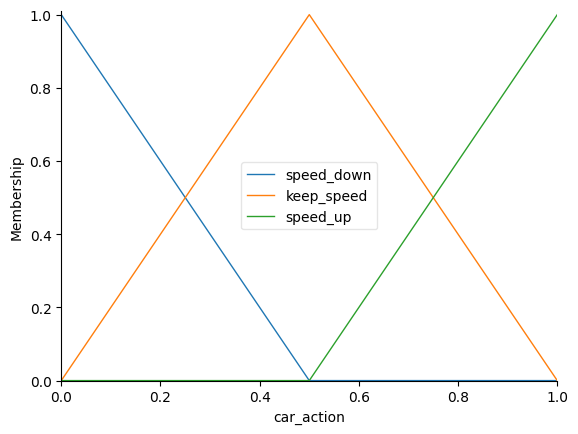

In [183]:
# speed_down - 0
# keep_speed - 0.5
# speed_up - 1

car_action = ctrl.Consequent([0, 0.5, 1], 'car_action', 'som')

car_action['speed_down'] = fuzz.trimf(car_action.universe, [0, 0, 0.5])
car_action['keep_speed'] = fuzz.trimf(car_action.universe, [0.25, 0.5, 0.75])
car_action['speed_up'] = fuzz.trimf(car_action.universe, [0.5, 1, 1])

car_action.view()

### Defining rules

In [184]:
rules = [
    ctrl.Rule(distance['small'] & speed['high'], car_action['speed_down']),
    ctrl.Rule(distance['small'] & speed['medium'], car_action['speed_down']),
    ctrl.Rule(distance['small'] & speed['low'], car_action['speed_down']),
                                                                                                     
    ctrl.Rule(distance['medium'] & speed['high'], car_action['speed_down']),
    ctrl.Rule(distance['medium'] & speed['medium'], car_action['keep_speed']),
    ctrl.Rule(distance['medium'] & speed['low'], car_action['speed_up']) ,
                                                                                                     
    ctrl.Rule(distance['large'] & speed['high'], car_action['keep_speed']),
    ctrl.Rule(distance['large'] & speed['medium'], car_action['speed_up']),
    ctrl.Rule(distance['large'] & speed['low'], car_action['speed_up']),
                                                                                                     
     ctrl.Rule(road_state['wet'] & distance['small'], car_action['speed_down']),
     ctrl.Rule(road_state['wet'] & speed['high'], car_action['speed_down']),
                                                                                                     
     ctrl.Rule(road_state['dry'] & distance['medium'] & speed['medium'], car_action['keep_speed']),
     ctrl.Rule(road_state['dry'] & distance['large'] & speed['high'], car_action['keep_speed']),
     ctrl.Rule(road_state['dry'] & speed['low'], car_action['keep_speed']),
                                                                                                     
     ctrl.Rule(road_state['wet'] & speed['medium'], car_action['keep_speed'])                        
]

braking_control = ctrl.ControlSystem(rules)

In [185]:
sim = ctrl.ControlSystemSimulation(braking_control)

sim.input['speed'] = 1  # low cost
sim.input['distance'] = 300  # high benefit
sim.input['road_state'] = 0  # high benefit    

sim.compute()

sim.print_state()

 Antecedents 
Antecedent: distance                = 300
  - small                           : 0.0
  - medium                          : 0.0
  - large                           : 0.0
Antecedent: speed                   = 1
  - low                             : 0.0
  - medium                          : 0.0
  - high                            : 0.0
Antecedent: road_state              = 0
  - dry                             : 0.0
  - wet                             : 0.0

 Rules 
RULE #0:
  IF distance[small] AND speed[high] THEN car_action[speed_down]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - distance[small]                                        : 0.0
  - speed[high]                                            : 0.0
                           distance[small] AND speed[high] = 0.0
  Activation (THEN-clause):
                                    car_action[speed_down] : 0.0

RULE #1:
  IF distance[small] AND speed[medium] THEN car_actio

In [186]:
print(f"Given inputs above, result is {sim.output['car_action']}")

Given inputs above, result is 0.0
